# Self-supervised Learning
The objective of this lab project is to go further in the understanding of Self-Supervised Learning (SSL). By the end of the notebook, you will
- Train models using different pretext tasks: colorizing, inpainting, masking reconstruction.
- Fine-tune the models with the downstream task of interst.
- Compare the performance of the different backbones obtained from the different downstream tasks.

## Library imports

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

import os

## Pretext and Downstream Tasks

We will train three different models using three different pretext tasks. All three models will be trained on the SVHN dataset. The three models are the following:
- A Colorization Neural Network
- An Inpainting Neural Network
- A Masked Autoencoder

We will build a common architecture so that all three models have as similar architectures as possible. The common architecture will consist of an encoder and a decoder. Once the models pre-trained on their respective pretext tasks, we will use the pre-trained encoders to evaluate the learnt representations on two new downstream task: image classification on MNIST and on SVHN. To that end, we will perform a linear evaluation protocol, by freezing the weights of the pre-trained encoders, and training a linear classifier on the learnt representations. 

# Hyperparameters

In [77]:
BATCH_SIZE = 128
RESIZE = 32
LATENT_DIM = 32

## Data Preparation

Download the datasets

Les données ont été convertit de png à jpg pour diminuer largement la taille des données (de 5,1Go à 165Mo) et augmenter largement la vitesse de calcul.
Les performance sont moins bonnes, cependant comme il s'agit d'une étude comparative et non une étude de performance, on s'attends à avoir une diminution de performance globale, ce qui n'est donc pas dérangeant car un modèle n'est pas favorisé plus qu'un autre. Il est donc possible de faire une comparaison des modèles.
A la fin, une étude de performance sera effectué avec le modèle le plus prometeur. 

Les datasets ont été modifié pour correspondre au demande du projet et son téléchargeable depuis un dépot github séparé du code.

In [58]:
# Crée un chemin relatif basé sur le dossier actuel
dataset_path = os.path.join(os.getcwd(), '../data/')

if not os.path.exists(dataset_path):
    os.makedirs(dataset_path, exist_ok=True)  # Crée le dossier et ses parents si nécessaire

    !git clone https://github.com/sourisimos/DATA_P3HDDL_MVTEC.git ../data/mvtec #Cloning mvtec dataset 
    !git clone https://github.com/sourisimos/DATA_P3HDDL_EW.git ../data/ew #Cloning ew datasets

    print(f"Dossiers téléchargés dans le dossier '{dataset_path}'.")


## Engine wiring dataset

In [78]:
# Define the transformations to apply to EW

transform_ew_val = transforms.Compose([
    transforms.Resize((RESIZE, RESIZE)),
    transforms.ToTensor()

])

transform_ew_train = transforms.Compose([
    transforms.Resize((RESIZE,RESIZE)),
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])


# Load EW dataset for train test and creating val
# Training
ew_train_dataset = datasets.ImageFolder(root='../data/ew/engine_wiring/train', transform=transform_ew_train)
ew_train_loader = DataLoader(ew_train_dataset, batch_size=BATCH_SIZE, shuffle=True )

# Test
ew_test_dataset = datasets.ImageFolder(root='../data/ew/engine_wiring/test', transform=transform_ew_val) 
ew_test_loader = DataLoader(ew_test_dataset, batch_size=BATCH_SIZE, shuffle=True)


# Device configuration

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## MVtec datasets

In [65]:
# Define the transformations to apply to the images
transform_mvtec = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),  
])

# Function to load the dataset mvtec 
def load_mvt_dataset(root='../data/mvtec/mvtec_anomaly_detection', batch_size=64, restricted = True):
    # List of categories you want to load
    categories = ['bottle', 'cable','capsule', 'carpet', 'grid','hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']  # Add other categories as needed
    # Restricted are just the essential one (for the academ project )
    if restricted: 
        categories = ['bottle','capsule', 'hazelnut', 'toothbrush']
        
    # Create dictionaries to hold loaders for training and test sets
    train_loaders = {}
    test_loaders = {}
    
    for category in categories:

        train_dataset = datasets.ImageFolder(root=f'{root}/{category}/train', transform=transform_mvtec)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        train_loaders[category] = train_loader
        
        test_dataset = datasets.ImageFolder(root=f'{root}/{category}/test', transform=transform_mvtec)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        test_loaders[category] = test_loader
        
    return train_loaders, test_loaders

train_loaders, test_loaders = load_mvt_dataset()

# Accessing a specific category's data loader
bottle_train_loader = train_loaders['bottle']
bottle_test_loader = test_loaders['bottle']

## Shared architecture
We will create a shared architecture with the following layers:
- The encoder (in sequential order):
    - A convolution with 64 filters, kernel size 4, stride 2, padding 1
    - A ReLU activation
    - A convolution with 128 filters, kernel size 4, stride2, padding 1
    - A ReLU activation
    - A convolution with `latent_dim`, kernel size 4, stride 2, padding 1
    - A ReLU activation
The encoder should take the number of channels of the input `in_channels` and the hidden dimension `latent_dim` as arguments.
- The decoder (in secuential ) order:
    - A Transpose convolution with 128 filters, kernel size 4, padding 1
    - A ReLU activation
    - A convolution with 16428 filters, kernel size 4, stride2, padding 1
    - A ReLU activation
    - A convolution with `out_channels` filters, kernel size 4, stride 2, padding 1
    - A ReLU activation
The encoder should take the number of channels of the output `out_channels` and the hidden dimension `latent_dim` as arguments.

In [79]:
class Encoder(nn.Module):
    def __init__(self, in_channels=3, latent_dim=128):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 8x8 -> 4x4
            nn.ReLU(),
            nn.Conv2d(256, latent_dim, kernel_size=4, stride=2, padding=1),  # 4x4 -> 2x2
            nn.ReLU(),
        )

    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim=128, out_channels=3):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=4, stride=2, padding=1),  # 2x2 -> 4x4
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.decoder(x)

In [80]:
def train_ssl_model(model, 
                    train_loader, 
                    val_loader, 
                    criterion,
                    optimizer,
                    device=device,
                    epochs=5):

    for epoch in range(epochs):
        model.to(device)
        model.train()
        total_train_loss = 0
        for images, _ in train_loader:
            images = images.to(device)
            optimizer.zero_grad()
            output, _ = model(images)
            loss = criterion(output, images)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(device)
                output, _ = model(images)
                val_loss = criterion(output, images)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}")
    
    return model

# Colorization model 

a de grande chance d'être nul dans le cadre de nos données

In [81]:
class ColorizationModel(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        super(ColorizationModel, self).__init__()
        self.encoder = Encoder(latent_dim=latent_dim, in_channels=1)  # Input grayscale
        self.decoder = Decoder(latent_dim=latent_dim, out_channels=3)  # Predict RGB

    def forward(self, x):
        grayscale_x = transforms.Grayscale()(x)  # Convert RGB to Grayscale
        z = self.encoder(grayscale_x)
        return self.decoder(z), grayscale_x

In [82]:
colorization_model = ColorizationModel(latent_dim=LATENT_DIM)
colorization_encoder = train_ssl_model(colorization_model, 
                                       ew_train_loader, 
                                       ew_test_loader, 
                                       criterion=nn.MSELoss(), 
                                       optimizer=optim.Adam(colorization_model.parameters(),lr=0.001),
                                       epochs = 50
                                       )

Epoch 1/50, Train Loss: 0.1042, Avg Val Loss: 0.0932
Epoch 2/50, Train Loss: 0.1040, Avg Val Loss: 0.0905
Epoch 3/50, Train Loss: 0.0964, Avg Val Loss: 0.0785
Epoch 4/50, Train Loss: 0.0835, Avg Val Loss: 0.0586
Epoch 5/50, Train Loss: 0.0669, Avg Val Loss: 0.0509
Epoch 6/50, Train Loss: 0.0563, Avg Val Loss: 0.0495
Epoch 7/50, Train Loss: 0.0541, Avg Val Loss: 0.0445
Epoch 8/50, Train Loss: 0.0503, Avg Val Loss: 0.0433
Epoch 9/50, Train Loss: 0.0488, Avg Val Loss: 0.0425
Epoch 10/50, Train Loss: 0.0446, Avg Val Loss: 0.0441
Epoch 11/50, Train Loss: 0.0441, Avg Val Loss: 0.0442
Epoch 12/50, Train Loss: 0.0402, Avg Val Loss: 0.0439
Epoch 13/50, Train Loss: 0.0405, Avg Val Loss: 0.0448
Epoch 14/50, Train Loss: 0.0402, Avg Val Loss: 0.0434
Epoch 15/50, Train Loss: 0.0387, Avg Val Loss: 0.0413
Epoch 16/50, Train Loss: 0.0385, Avg Val Loss: 0.0405
Epoch 17/50, Train Loss: 0.0375, Avg Val Loss: 0.0437
Epoch 18/50, Train Loss: 0.0360, Avg Val Loss: 0.0405
Epoch 19/50, Train Loss: 0.0366, Avg 

# Inpainting model 

In [43]:
class InpaintingModel(nn.Module):
    def __init__(self, latent_dim=128, mask_size=8):
        super(InpaintingModel, self).__init__()
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim)
        self.mask_size = mask_size

    def forward(self, x):
        x_masked = self.apply_mask(x)
        z = self.encoder(x_masked)
        return self.decoder(z), x_masked
    
    def apply_mask(self, x):
        masked_x = x.clone()

        for i in range(masked_x.size(0)):
            ul_x = np.random.randint(0, x.size(2) - self.mask_size + 1)
            ul_y = np.random.randint(0, x.size(3) - self.mask_size + 1)
            masked_x[i, :, ul_x:ul_x+self.mask_size, ul_y:ul_y+self.mask_size] = 0

        return masked_x

In [45]:
inpainting_model = InpaintingModel(latent_dim=LATENT_DIM, mask_size=8)
inpainting_encoder = train_ssl_model(inpainting_model,
                                     ew_train_loader, 
                                     ew_test_loader, 
                                     criterion=nn.MSELoss(), 
                                     optimizer=optim.Adam(inpainting_model.parameters(),lr=0.001),
                                     epochs = 50
                                     )

Epoch 1/50, Train Loss: 0.1017, Avg Val Loss: 0.0916
Epoch 2/50, Train Loss: 0.1007, Avg Val Loss: 0.0893
Epoch 3/50, Train Loss: 0.0965, Avg Val Loss: 0.0744
Epoch 4/50, Train Loss: 0.0777, Avg Val Loss: 0.0541
Epoch 5/50, Train Loss: 0.0664, Avg Val Loss: 0.0493
Epoch 6/50, Train Loss: 0.0588, Avg Val Loss: 0.0478
Epoch 7/50, Train Loss: 0.0542, Avg Val Loss: 0.0437
Epoch 8/50, Train Loss: 0.0529, Avg Val Loss: 0.0435
Epoch 9/50, Train Loss: 0.0489, Avg Val Loss: 0.0440
Epoch 10/50, Train Loss: 0.0446, Avg Val Loss: 0.0465
Epoch 11/50, Train Loss: 0.0443, Avg Val Loss: 0.0438
Epoch 12/50, Train Loss: 0.0417, Avg Val Loss: 0.0430
Epoch 13/50, Train Loss: 0.0410, Avg Val Loss: 0.0427
Epoch 14/50, Train Loss: 0.0406, Avg Val Loss: 0.0403
Epoch 15/50, Train Loss: 0.0379, Avg Val Loss: 0.0392
Epoch 16/50, Train Loss: 0.0375, Avg Val Loss: 0.0423
Epoch 17/50, Train Loss: 0.0364, Avg Val Loss: 0.0416
Epoch 18/50, Train Loss: 0.0349, Avg Val Loss: 0.0398
Epoch 19/50, Train Loss: 0.0354, Avg 

# Masked AE Model

In [47]:
class MaskedAutoencoderModel(nn.Module):
    def __init__(self, latent_dim=32, mask_ratio=1/16):
        super(MaskedAutoencoderModel, self).__init__()
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim)
        self.mask_ratio = mask_ratio

    def forward(self, x):
        x_masked = self.apply_mask(x)
        z = self.encoder(x_masked)
        return self.decoder(z), x_masked
    
    def apply_mask(self, x):
        x_masked = x.clone()
        mask = torch.rand_like(x[:, 0, :, :]) < self.mask_ratio
        mask = mask.unsqueeze(1).repeat(1, x.size(1), 1, 1)
        x_masked[mask] = 0
        return x_masked

In [48]:
mae_model = MaskedAutoencoderModel(latent_dim=LATENT_DIM, mask_ratio=1/16)
mae_encoder = train_ssl_model(mae_model,
                              ew_train_loader, 
                              ew_test_loader, 
                              criterion=nn.MSELoss(), 
                              optimizer=optim.Adam(mae_model.parameters(),lr=0.001),
                              epochs = 50
                              )

Epoch 1/50, Train Loss: 0.1016, Avg Val Loss: 0.0907
Epoch 2/50, Train Loss: 0.0994, Avg Val Loss: 0.0790
Epoch 3/50, Train Loss: 0.0858, Avg Val Loss: 0.0605
Epoch 4/50, Train Loss: 0.0678, Avg Val Loss: 0.0553
Epoch 5/50, Train Loss: 0.0589, Avg Val Loss: 0.0494
Epoch 6/50, Train Loss: 0.0540, Avg Val Loss: 0.0463
Epoch 7/50, Train Loss: 0.0516, Avg Val Loss: 0.0439
Epoch 8/50, Train Loss: 0.0483, Avg Val Loss: 0.0453
Epoch 9/50, Train Loss: 0.0463, Avg Val Loss: 0.0455
Epoch 10/50, Train Loss: 0.0440, Avg Val Loss: 0.0445
Epoch 11/50, Train Loss: 0.0418, Avg Val Loss: 0.0432
Epoch 12/50, Train Loss: 0.0403, Avg Val Loss: 0.0449
Epoch 13/50, Train Loss: 0.0397, Avg Val Loss: 0.0450
Epoch 14/50, Train Loss: 0.0380, Avg Val Loss: 0.0429
Epoch 15/50, Train Loss: 0.0373, Avg Val Loss: 0.0410
Epoch 16/50, Train Loss: 0.0364, Avg Val Loss: 0.0441
Epoch 17/50, Train Loss: 0.0358, Avg Val Loss: 0.0421
Epoch 18/50, Train Loss: 0.0355, Avg Val Loss: 0.0412
Epoch 19/50, Train Loss: 0.0352, Avg 

# Contrastive Model

## Specific datas for contrastive model

In [139]:
from torchvision import datasets, transforms

# Définissez les transformations
transform_train_cm = transforms.Compose([
    transforms.Resize((RESIZE, RESIZE)),
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])

transform_val_cm = transforms.Compose([
    transforms.Resize((RESIZE, RESIZE)),
    transforms.ToTensor()
])


# Define the Contrastive Dataset
class ContrastiveDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get original image and its label (if applicable, ignored here)
        img, label = self.dataset[idx]
        
        # Apply transformation to create a positive pair
        img1 = self.transform(img) if self.transform else img
        img2 = self.transform(img) if self.transform else img
        
        return img1.float(), img2.float(), label
    
# Chargez les datasets d'origine avec ImageFolder sans transformation
ew_train_dataset = datasets.ImageFolder(root='../data/ew/engine_wiring/train', transform=None)
ew_test_dataset = datasets.ImageFolder(root='../data/ew/engine_wiring/test', transform=None)

# Utilisez ContrastiveDataset pour créer des paires positives
contrastive_train_dataset = ContrastiveDataset(ew_train_dataset, transform=transform_train_cm)
contrastive_test_dataset = ContrastiveDataset(ew_test_dataset, transform=transform_val_cm)

# Créez les DataLoaders
BATCH_SIZE = 32
ew_train_loader_cm = DataLoader(contrastive_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
ew_test_loader_cm = DataLoader(contrastive_test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [82]:
# Define the Projection Head
class ProjectionHead(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ProjectionHead, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


class ContrastiveModel(nn.Module):
    def __init__(self, in_channels=3, latent_dim=32, projection_dim=128):
        super(ContrastiveModel, self).__init__()
        self.encoder = Encoder(in_channels=in_channels, latent_dim=latent_dim)
        
        # Ajustez input_dim en fonction de la sortie de l'encodeur
        # En supposant que la sortie de l'encodeur est de dimension (256, 2, 2)
        input_dim = 256 * 2 * 2
        self.projection_head = ProjectionHead(input_dim=input_dim, output_dim=projection_dim)

    def forward(self, x):
        features = self.encoder(x)
        features_flat = features.view(features.size(0), -1)
        projections = self.projection_head(features_flat)
        return projections

    

# Define the Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.1):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z1, z2):
        z1 = F.normalize(z1, dim=-1)
        z2 = F.normalize(z2, dim=-1)
        similarity = torch.mm(z1, z2.T) / self.temperature
        labels = torch.arange(z1.size(0)).to(z1.device)
        loss = F.cross_entropy(similarity, labels)
        return loss


# Training loop for contrastive learning
def train_contrastive_model(model, criterion, optimizer, train_loader, val_loader, epochs=5):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for img1, img2, _ in train_loader:
            img1, img2 = img1.to(device), img2.to(device)

            optimizer.zero_grad()
            z1 = model(img1)
            z2 = model(img2)

            loss = criterion(z1, z2)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for img1, img2, _ in val_loader:
                img1, img2 = img1.to(device), img2.to(device)
                
                z1 = model(img1)
                z2 = model(img2)

                val_loss = criterion(z1, z2)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}")


In [83]:
# Train the contrastive model

model_contrast = ContrastiveModel(latent_dim=LATENT_DIM).to(device)
contrastive_loss = ContrastiveLoss().to(device)
optimizer = optim.Adam(model_contrast.parameters(), lr=1e-3)

train_contrastive_model(model_contrast, contrastive_loss, optimizer ,ew_train_loader, ew_test_loader, epochs=5)


Epoch 1/5, Train Loss: 3.4675, Avg Val Loss: 3.4590
Epoch 2/5, Train Loss: 3.4496, Avg Val Loss: 3.4215
Epoch 3/5, Train Loss: 3.4259, Avg Val Loss: 3.3979
Epoch 4/5, Train Loss: 3.4533, Avg Val Loss: 3.4613
Epoch 5/5, Train Loss: 3.4428, Avg Val Loss: 3.1320


# Anomaly detection 

In [85]:
class AnomalyDetectionModel(nn.Module):
    def __init__(self, model):

        super(AnomalyDetectionModel, self).__init__()
        self.model = model

    def forward(self, x):

        x_reconstructed, _ = self.model.forward(x)
        return x_reconstructed

    def compute_anomaly_score(self, x):
    
        x_reconstructed = self.forward(x)
        loss_fn = nn.MSELoss(reduction='none')
        per_pixel_loss = loss_fn(x_reconstructed, x)
        anomaly_score = per_pixel_loss.sum(dim=(1, 2, 3))  # Moyenne sur H, W, C
    
        return anomaly_score


    def evaluate_anomaly_detection(self, dataloader):
        
        self.model.eval()
        scores = []
        labels = []
    
        with torch.no_grad():
            for batch, label in dataloader: 
                x = batch.to(device)
                label = label.to(device)
                
                # Calculer les scores d'anomalie
                score = self.compute_anomaly_score(x)
                
                scores.extend(score.cpu().numpy())
                labels.extend(label.cpu().numpy())
        
        return scores, labels


#### Fine tuning 

In [86]:

def fine_tune_anomaly_detection(model, train_loader, valid_loader, epochs=10, lr=1e-5):


    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    history = {"train_loss": [], "val_loss": []}

    for epoch in range(epochs):
        # Phase d'entraînement
        model.train()
        train_loss = 0
        for batch, _ in train_loader:
            x = batch.to(device)
            optimizer.zero_grad()
            
            # Reconstruction
            reconstructed = model(x)
            loss = criterion(reconstructed, x)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        history["train_loss"].append(train_loss)

        # Phase de validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch, _ in valid_loader:
                x = batch.to(device)
                reconstructed = model(x)
                loss = criterion(reconstructed, x)
                val_loss += loss.item()

        val_loss /= len(valid_loader)
        history["val_loss"].append(val_loss)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return history


In [87]:
def plot_roc_curve(y_true, y_scores):

    # Calcul des courbes ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Tracé de la courbe ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance level')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Résults

Epoch 1/10, Train Loss: 0.0207, Val Loss: 0.0243
Epoch 2/10, Train Loss: 0.0216, Val Loss: 0.0243
Epoch 3/10, Train Loss: 0.0205, Val Loss: 0.0242
Epoch 4/10, Train Loss: 0.0211, Val Loss: 0.0243
Epoch 5/10, Train Loss: 0.0208, Val Loss: 0.0242
Epoch 6/10, Train Loss: 0.0203, Val Loss: 0.0243
Epoch 7/10, Train Loss: 0.0204, Val Loss: 0.0243
Epoch 8/10, Train Loss: 0.0198, Val Loss: 0.0243
Epoch 9/10, Train Loss: 0.0208, Val Loss: 0.0242
Epoch 10/10, Train Loss: 0.0207, Val Loss: 0.0242


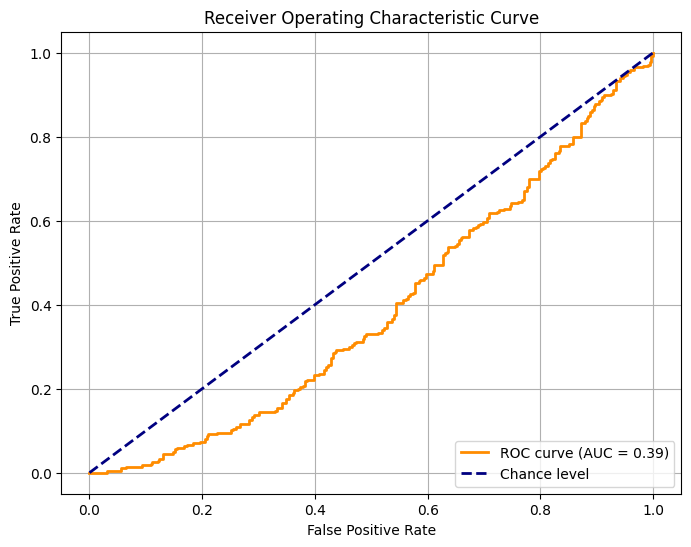

In [88]:
color_anomali = AnomalyDetectionModel(colorization_encoder)

# Finetuning ! 
history = fine_tune_anomaly_detection(color_anomali, ew_train_loader, ew_test_loader, 10, 1e-5)

scores, labels = color_anomali.evaluate_anomaly_detection(ew_test_loader)

# Plotting roc curbe
plot_roc_curve(labels, scores)

Epoch 1/50, Train Loss: 0.0223, Val Loss: 0.0256
Epoch 2/50, Train Loss: 0.0217, Val Loss: 0.0256
Epoch 3/50, Train Loss: 0.0221, Val Loss: 0.0254
Epoch 4/50, Train Loss: 0.0226, Val Loss: 0.0254
Epoch 5/50, Train Loss: 0.0224, Val Loss: 0.0254
Epoch 6/50, Train Loss: 0.0229, Val Loss: 0.0252
Epoch 7/50, Train Loss: 0.0214, Val Loss: 0.0254
Epoch 8/50, Train Loss: 0.0221, Val Loss: 0.0254
Epoch 9/50, Train Loss: 0.0215, Val Loss: 0.0253
Epoch 10/50, Train Loss: 0.0221, Val Loss: 0.0254
Epoch 11/50, Train Loss: 0.0218, Val Loss: 0.0255
Epoch 12/50, Train Loss: 0.0216, Val Loss: 0.0254
Epoch 13/50, Train Loss: 0.0213, Val Loss: 0.0253
Epoch 14/50, Train Loss: 0.0221, Val Loss: 0.0256
Epoch 15/50, Train Loss: 0.0218, Val Loss: 0.0254
Epoch 16/50, Train Loss: 0.0214, Val Loss: 0.0254
Epoch 17/50, Train Loss: 0.0210, Val Loss: 0.0253
Epoch 18/50, Train Loss: 0.0215, Val Loss: 0.0254
Epoch 19/50, Train Loss: 0.0215, Val Loss: 0.0252
Epoch 20/50, Train Loss: 0.0209, Val Loss: 0.0252
Epoch 21/

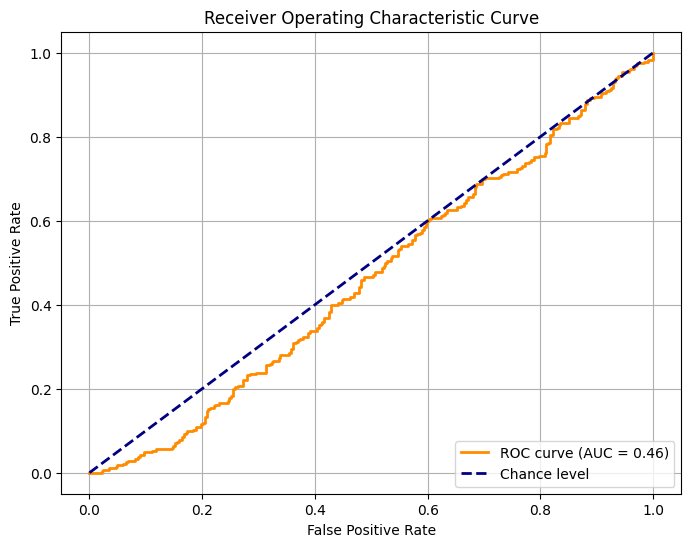

In [46]:
inpainting_anomali = AnomalyDetectionModel(inpainting_encoder)

# Finetuning ! 
history = fine_tune_anomaly_detection(inpainting_anomali, ew_train_loader, ew_test_loader, 50, 1e-5)



scores, labels = inpainting_anomali.evaluate_anomaly_detection(ew_test_loader)

# Plotting roc curbe
plot_roc_curve(labels, scores)

Epoch 1/10, Train Loss: 0.0212, Val Loss: 0.0235
Epoch 2/10, Train Loss: 0.0208, Val Loss: 0.0235
Epoch 3/10, Train Loss: 0.0214, Val Loss: 0.0236
Epoch 4/10, Train Loss: 0.0214, Val Loss: 0.0235
Epoch 5/10, Train Loss: 0.0203, Val Loss: 0.0236
Epoch 6/10, Train Loss: 0.0204, Val Loss: 0.0235
Epoch 7/10, Train Loss: 0.0201, Val Loss: 0.0235
Epoch 8/10, Train Loss: 0.0198, Val Loss: 0.0234
Epoch 9/10, Train Loss: 0.0198, Val Loss: 0.0234
Epoch 10/10, Train Loss: 0.0199, Val Loss: 0.0234


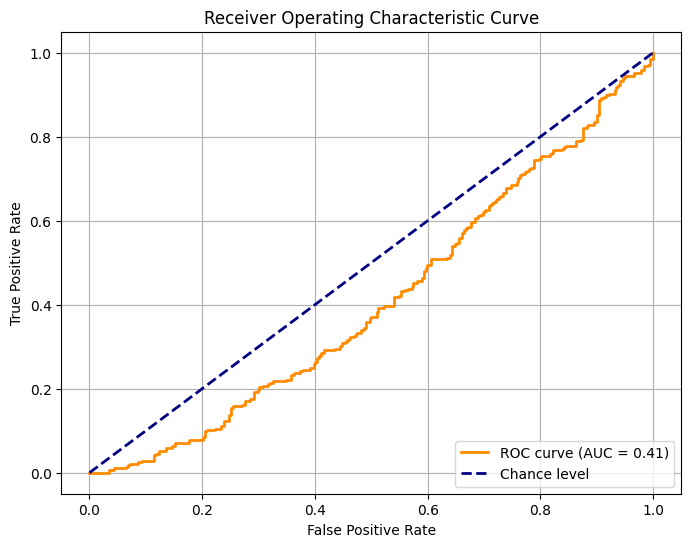

In [49]:
mae_anomali = AnomalyDetectionModel(mae_encoder)

# Finetuning ! 
history = fine_tune_anomaly_detection(mae_anomali, ew_train_loader, ew_test_loader, 10, 1e-5)



scores, labels = mae_anomali.evaluate_anomaly_detection(ew_test_loader)

# Plotting roc curbe
plot_roc_curve(labels, scores)